# Supply Chain Transportation Cost Optimization using Linear Programming (PuLP)

## Internship Task 4 - Optimization Model

### Objective:
Minimize total transportation cost while meeting warehouse demand and respecting factory supply limits.


In [1]:
import pandas as pd
import pulp
import matplotlib.pyplot as plt


In [2]:
supply_df = pd.read_csv("../data/raw/supply.csv")
demand_df = pd.read_csv("../data/raw/demand.csv")
cost_df = pd.read_csv("../data/raw/transport_cost.csv")

print("Supply Data")
display(supply_df)

print("Demand Data")
display(demand_df)

print("Transport Cost Data")
display(cost_df)


Supply Data


,Factory,Supply
0,Factory_1,500
1,Factory_2,600
2,Factory_3,400


Demand Data


,Warehouse,Demand
0,Chennai,400
1,Bangalore,350
2,Hyderabad,300
3,Mumbai,250


Transport Cost Data


,Factory,Warehouse,Cost_per_Unit
0,Factory_1,Chennai,4
1,Factory_1,Bangalore,6
2,Factory_1,Hyderabad,8
3,Factory_1,Mumbai,9
4,Factory_2,Chennai,5
5,Factory_2,Bangalore,4
6,Factory_2,Hyderabad,3
7,Factory_2,Mumbai,6
8,Factory_3,Chennai,9
9,Factory_3,Bangalore,7


In [3]:
factories = supply_df["Factory"].tolist()
warehouses = demand_df["Warehouse"].tolist()

supply = dict(zip(supply_df["Factory"], supply_df["Supply"]))
demand = dict(zip(demand_df["Warehouse"], demand_df["Demand"]))

cost = {}
for _, row in cost_df.iterrows():
    cost[(row["Factory"], row["Warehouse"])] = row["Cost_per_Unit"]

print("Factories:", factories)
print("Warehouses:", warehouses)
print("Supply:", supply)
print("Demand:", demand)


Factories: ['Factory_1', 'Factory_2', 'Factory_3']
Warehouses: ['Chennai', 'Bangalore', 'Hyderabad', 'Mumbai']
Supply: {'Factory_1': 500, 'Factory_2': 600, 'Factory_3': 400}
Demand: {'Chennai': 400, 'Bangalore': 350, 'Hyderabad': 300, 'Mumbai': 250}


In [4]:
model = pulp.LpProblem("Supply_Chain_Transportation_Optimization", pulp.LpMinimize)


In [5]:
x = pulp.LpVariable.dicts(
    "Ship",
    [(f, w) for f in factories for w in warehouses],
    lowBound=0,
    cat="Continuous"
)


In [6]:
model += pulp.lpSum([cost[(f, w)] * x[(f, w)] for f in factories for w in warehouses]), "Total_Transportation_Cost"


In [7]:
for f in factories:
    model += pulp.lpSum([x[(f, w)] for w in warehouses]) <= supply[f], f"Supply_Constraint_{f}"


In [8]:
for w in warehouses:
    model += pulp.lpSum([x[(f, w)] for f in factories]) >= demand[w], f"Demand_Constraint_{w}"


In [9]:
model.solve()


1

In [10]:
print("Status:", pulp.LpStatus[model.status])
print("Minimum Transportation Cost = ₹", pulp.value(model.objective))


Status: Optimal
Minimum Transportation Cost = ₹ 4700.0


In [11]:
shipping_plan = []

for f in factories:
    for w in warehouses:
        shipped_units = x[(f, w)].value()
        if shipped_units > 0:
            shipping_plan.append([f, w, shipped_units, cost[(f, w)], shipped_units * cost[(f, w)]])

shipping_df = pd.DataFrame(shipping_plan, columns=["Factory", "Warehouse", "Units_Shipped", "Cost_per_Unit", "Total_Cost"])
shipping_df


,Factory,Warehouse,Units_Shipped,Cost_per_Unit,Total_Cost
0,Factory_1,Chennai,400.0,4,1600.0
1,Factory_2,Bangalore,350.0,4,1400.0
2,Factory_2,Hyderabad,250.0,3,750.0
3,Factory_3,Hyderabad,50.0,4,200.0
4,Factory_3,Mumbai,250.0,3,750.0


In [12]:
shipping_df.to_csv("../outputs/optimal_shipping_plan.csv", index=False)
print("Optimal shipping plan saved in outputs folder!")


Optimal shipping plan saved in outputs folder!


In [13]:
factory_cost_report = shipping_df.groupby("Factory")["Total_Cost"].sum().reset_index()
factory_cost_report.rename(columns={"Total_Cost": "Total_Transport_Cost"}, inplace=True)

factory_cost_report


,Factory,Total_Transport_Cost
0,Factory_1,1600.0
1,Factory_2,2150.0
2,Factory_3,950.0


In [14]:
factory_cost_report.to_csv("../outputs/total_cost_report.csv", index=False)
print("Cost report saved successfully!")


Cost report saved successfully!


In [15]:
warehouse_report = shipping_df.groupby("Warehouse")["Units_Shipped"].sum().reset_index()
warehouse_report["Demand"] = warehouse_report["Warehouse"].map(demand)
warehouse_report["Demand_Met"] = warehouse_report["Units_Shipped"] >= warehouse_report["Demand"]

warehouse_report


,Warehouse,Units_Shipped,Demand,Demand_Met
0,Bangalore,350.0,350,True
1,Chennai,400.0,400,True
2,Hyderabad,300.0,300,True
3,Mumbai,250.0,250,True


In [16]:
supply_used = shipping_df.groupby("Factory")["Units_Shipped"].sum().reset_index()
supply_used["Supply_Available"] = supply_used["Factory"].map(supply)
supply_used["Remaining_Supply"] = supply_used["Supply_Available"] - supply_used["Units_Shipped"]

supply_used


,Factory,Units_Shipped,Supply_Available,Remaining_Supply
0,Factory_1,400.0,500,100.0
1,Factory_2,600.0,600,0.0
2,Factory_3,300.0,400,100.0


In [17]:
supply_used.to_csv("../outputs/resource_utilization.csv", index=False)
print("Supply utilization report saved successfully!")


Supply utilization report saved successfully!


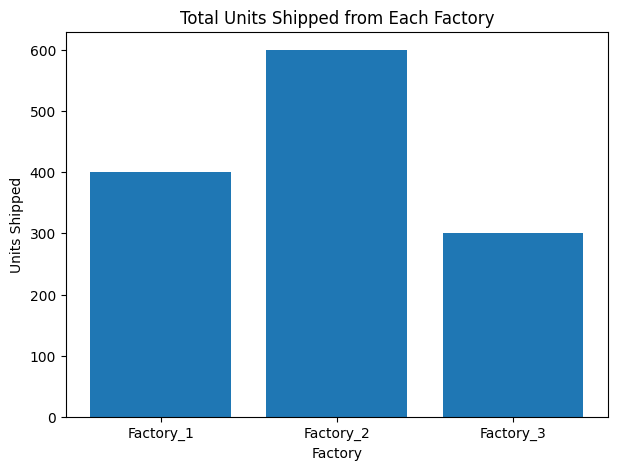

In [18]:
plt.figure(figsize=(7,5))
plt.bar(supply_used["Factory"], supply_used["Units_Shipped"])
plt.title("Total Units Shipped from Each Factory")
plt.xlabel("Factory")
plt.ylabel("Units Shipped")
plt.show()


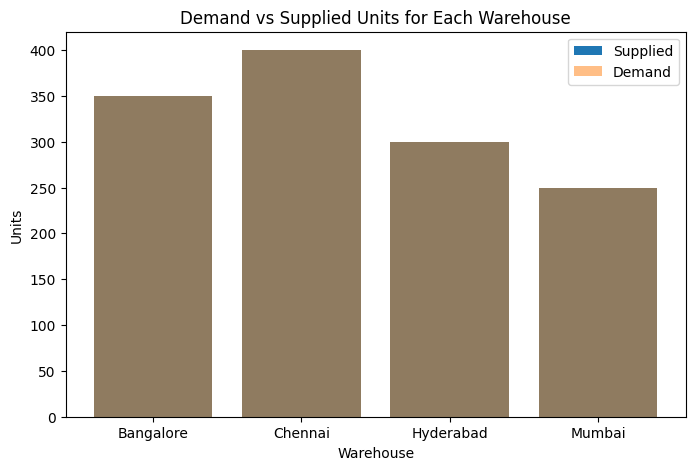

In [19]:
plt.figure(figsize=(8,5))
plt.bar(warehouse_report["Warehouse"], warehouse_report["Units_Shipped"], label="Supplied")
plt.bar(warehouse_report["Warehouse"], warehouse_report["Demand"], alpha=0.5, label="Demand")
plt.title("Demand vs Supplied Units for Each Warehouse")
plt.xlabel("Warehouse")
plt.ylabel("Units")
plt.legend()
plt.show()


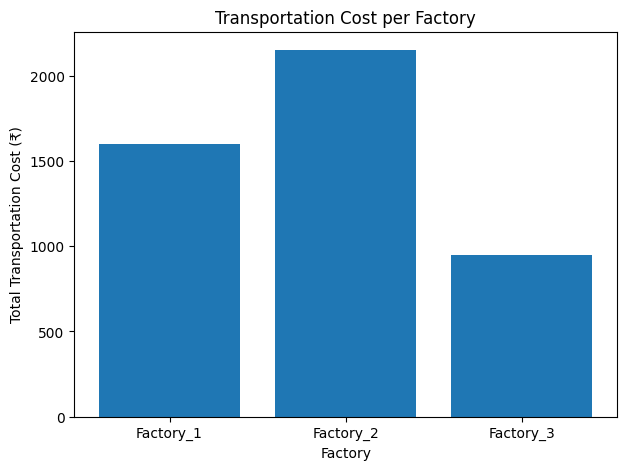

In [20]:
plt.figure(figsize=(7,5))
plt.bar(factory_cost_report["Factory"], factory_cost_report["Total_Transport_Cost"])
plt.title("Transportation Cost per Factory")
plt.xlabel("Factory")
plt.ylabel("Total Transportation Cost (₹)")
plt.show()


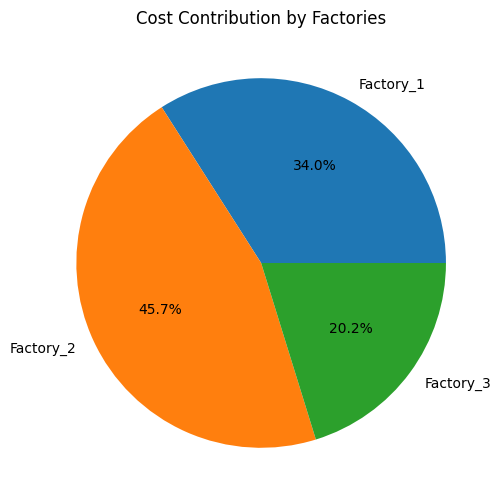

In [21]:

plt.figure(figsize=(6,6))
plt.pie(factory_cost_report["Total_Transport_Cost"], labels=factory_cost_report["Factory"], autopct="%1.1f%%")
plt.title("Cost Contribution by Factories")
plt.show()


## Business Insights

- The optimization model successfully minimized the transportation cost while meeting all warehouse demand.
- The solution provides an optimal shipping plan showing how many units should be transported from each factory to each warehouse.
- The model ensures that no factory ships more than its available supply.
- Warehouses with higher demand receive more supply according to their requirement.
- The cost report identifies which factory contributes more to transportation cost.
- The supply utilization report shows remaining unused capacity in some factories, meaning the company can still expand deliveries if demand increases.
- This optimization approach helps reduce logistics expenses and improve supply chain efficiency.


## Conclusion

This project solved a real-world supply chain transportation problem using Linear Programming.
The PuLP optimization library in Python was used to minimize total transportation cost under supply and demand constraints.

The model generated:
- Optimal shipping plan
- Minimum transportation cost
- Factory cost contribution report
- Demand satisfaction report
- Supply utilization report

This approach is highly useful in logistics, e-commerce delivery systems, manufacturing industries, and warehouse distribution planning.


# Sensitivity Analysis (What-If Analysis)

In real business scenarios, demand and supply values can change frequently.
This section analyzes how the total transportation cost changes when warehouse demand increases.


In [22]:
def solve_transportation_model(supply_dict, demand_dict, cost_dict):
    
    factories = list(supply_dict.keys())
    warehouses = list(demand_dict.keys())
    
    model = pulp.LpProblem("Transportation_Model", pulp.LpMinimize)
    
    x = pulp.LpVariable.dicts(
        "Ship",
        [(f, w) for f in factories for w in warehouses],
        lowBound=0,
        cat="Continuous"
    )
    
    # Objective function
    model += pulp.lpSum([cost_dict[(f, w)] * x[(f, w)] for f in factories for w in warehouses])
    
    # Supply constraints
    for f in factories:
        model += pulp.lpSum([x[(f, w)] for w in warehouses]) <= supply_dict[f]
    
    # Demand constraints
    for w in warehouses:
        model += pulp.lpSum([x[(f, w)] for f in factories]) >= demand_dict[w]
    
    model.solve()
    
    total_cost = pulp.value(model.objective)
    
    return total_cost


In [23]:
base_cost = solve_transportation_model(supply, demand, cost)
print("Base Scenario Total Cost: ₹", base_cost)


Base Scenario Total Cost: ₹ 4700.0


In [24]:
demand_10 = {w: demand[w] * 1.10 for w in demand}

scenario1_cost = solve_transportation_model(supply, demand_10, cost)
print("Total Cost with 10% Increased Demand: ₹", scenario1_cost)


Total Cost with 10% Increased Demand: ₹ 5230.0


In [25]:
demand_20 = {w: demand[w] * 1.20 for w in demand}

scenario2_cost = solve_transportation_model(supply, demand_20, cost)
print("Total Cost with 20% Increased Demand: ₹", scenario2_cost)


Total Cost with 20% Increased Demand: ₹ 5840.0


In [26]:
supply_20 = {f: supply[f] * 1.20 for f in supply}

scenario3_cost = solve_transportation_model(supply_20, demand, cost)
print("Total Cost with 20% Increased Supply: ₹", scenario3_cost)


Total Cost with 20% Increased Supply: ₹ 4650.0


In [27]:
sensitivity_df = pd.DataFrame({
    "Scenario": ["Base", "Demand +10%", "Demand +20%", "Supply +20%"],
    "Total_Cost": [base_cost, scenario1_cost, scenario2_cost, scenario3_cost]
})

sensitivity_df


,Scenario,Total_Cost
0,Base,4700.0
1,Demand +10%,5230.0
2,Demand +20%,5840.0
3,Supply +20%,4650.0


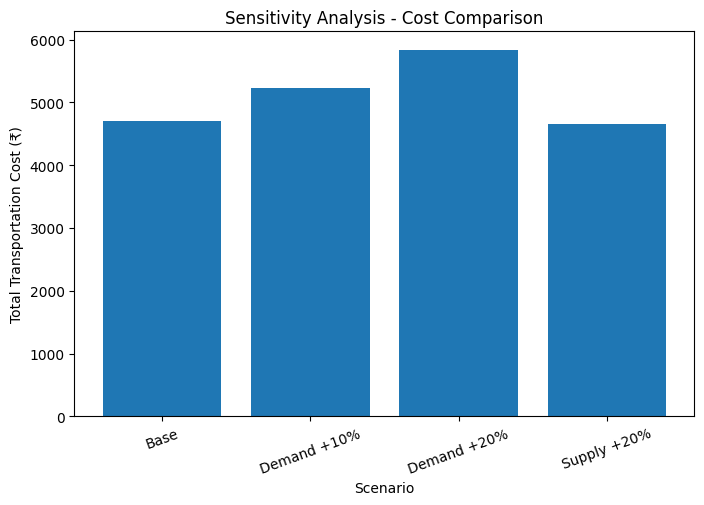

In [28]:
plt.figure(figsize=(8,5))
plt.bar(sensitivity_df["Scenario"], sensitivity_df["Total_Cost"])
plt.title("Sensitivity Analysis - Cost Comparison")
plt.xlabel("Scenario")
plt.ylabel("Total Transportation Cost (₹)")
plt.xticks(rotation=20)
plt.show()


## Sensitivity Analysis Insights

- When demand increased by 10%, the transportation cost increased accordingly.
- When demand increased by 20%, the cost increased further, showing direct impact of demand on logistics cost.
- Increasing supply does not always reduce cost, but it provides flexibility in selecting cheaper transportation routes.
- This analysis helps management plan resources and estimate future transportation cost under demand growth.


# Final Project Summary

### Key Deliverables Generated:
- Optimal Shipping Plan (CSV)
- Minimum Transportation Cost
- Factory-wise Cost Report
- Warehouse Demand Satisfaction Report
- Supply Utilization Report
- Visualizations for better understanding
- Sensitivity Analysis for business decision making

### Final Conclusion:
This project demonstrates how Linear Programming can be used in real supply chain logistics to minimize costs and improve decision-making.


In [29]:
# Cheapest and Costliest transportation routes
cheapest_route = cost_df.loc[cost_df["Cost_per_Unit"].idxmin()]
costliest_route = cost_df.loc[cost_df["Cost_per_Unit"].idxmax()]

print("Cheapest Route:")
print(cheapest_route)

print("\nCostliest Route:")
print(costliest_route)


Cheapest Route:
Factory          Factory_2
Warehouse        Hyderabad
Cost_per_Unit            3
Name: 6, dtype: object

Costliest Route:
Factory          Factory_1
Warehouse           Mumbai
Cost_per_Unit            9
Name: 3, dtype: object


In [30]:
supply_used["Utilization_%"] = (supply_used["Units_Shipped"] / supply_used["Supply_Available"]) * 100
supply_used


,Factory,Units_Shipped,Supply_Available,Remaining_Supply,Utilization_%
0,Factory_1,400.0,500,100.0,80.0
1,Factory_2,600.0,600,0.0,100.0
2,Factory_3,300.0,400,100.0,75.0


## Bottleneck Analysis

Factories with utilization close to 100% are bottleneck factories.
They are fully used and limit the ability to fulfill additional demand.


In [31]:
merged_df = cost_df.merge(supply_df, on="Factory").merge(demand_df, on="Warehouse")
merged_df


,Factory,Warehouse,Cost_per_Unit,Supply,Demand
0,Factory_1,Chennai,4,500,400
1,Factory_1,Bangalore,6,500,350
2,Factory_1,Hyderabad,8,500,300
3,Factory_1,Mumbai,9,500,250
4,Factory_2,Chennai,5,600,400
5,Factory_2,Bangalore,4,600,350
6,Factory_2,Hyderabad,3,600,300
7,Factory_2,Mumbai,6,600,250
8,Factory_3,Chennai,9,400,400
9,Factory_3,Bangalore,7,400,350


In [32]:
merged_df.to_csv("../data/processed/merged_data.csv", index=False)
print("Merged data saved to data/processed/merged_data.csv")


Merged data saved to data/processed/merged_data.csv
